# Preparation

## Directory and imports

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training

## Imports

In [9]:
from DataLoader import GamesMemoryBank
from policy_loss import PolicyLoss
from Model import PolicyNetwork, NET_INPUT_SIZE
from simulation import QuantumEnvironment 

import torch
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from os.path import isfile
from scipy.ndimage import uniform_filter1d

plt.style.use({'figure.facecolor':'white'})

## Initialization

### Constants

In [10]:
n_epochs = 1000
games_per_epoch = 10
batch_size = 24000
num_batches = 5
learning_rate = 1e-3

### Classes

In [11]:
run_time = 15
dt = 0.01
env = QuantumEnvironment(energy_gap=1, runtime=run_time, dt=dt)

loss_func = PolicyLoss()
net = PolicyNetwork()

model_name = 'trained_model.pt'
# If such a previous model exists
# if isfile(model_name):
#     net.load_state_dict(torch.load(model_name))

memory_bank = GamesMemoryBank()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

## Training loop

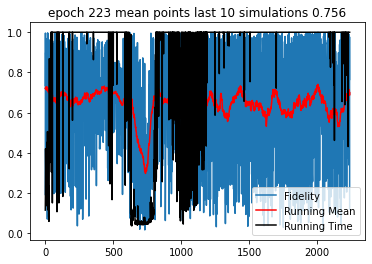

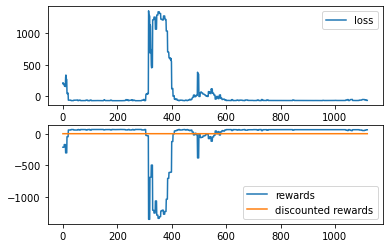

 22%|██▏       | 224/1000 [4:40:42<16:12:26, 75.19s/it]


KeyboardInterrupt: 

In [12]:
final_fidelity = []
running_mean_fid = []
losses = []
rewards = []
discounted_rewards = []
running_time = []

for epoch in tqdm(range(n_epochs)):
    
    memory_bank.clear_memory()
    
    net.eval()
    net.cpu()
    
    for game_i in range(games_per_epoch):

        state, prev_state = env.reset(), None

        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        prev_state = state

        while True:
            with torch.no_grad():
                action, action_p = net.sample_action(state)
            new_state, reward, done, info = env.step(action)
            memory_bank.add_event(state, action, action_p, reward)
            
            prev_state = state
            state = torch.tensor(new_state, dtype=torch.float).view(-1).unsqueeze(0)

            if done:
                final_fidelity.append(env.fidelity())
                running_time.append(env.steps*dt/run_time)
                break

    memory_bank.compute_reward_history()
    
    clear_output(wait=True)
    mean_fid = np.mean(final_fidelity[-games_per_epoch:])
    running_mean_fid = uniform_filter1d(final_fidelity,50)
    mean_fid = str(mean_fid)[:5]
    plt.title('epoch ' + str(epoch) 
                       + ' mean points last ' 
                       + str(games_per_epoch) 
                       + ' simulations '
                       + mean_fid)
    plt.plot(final_fidelity, label='Fidelity')
    plt.plot(running_mean_fid, label='Running Mean', color='red')
    plt.plot(running_time, label='Running Time', color='black')
    plt.legend()
    plt.show()

    net.train()
    
    for batch_i in range(num_batches):
        optimizer.zero_grad()

        state, action, action_p, reward, discounted_reward = memory_bank.get_sample(batch_size)
        state = state.view((state.shape[0], NET_INPUT_SIZE))
        
        logits = net(state)

        loss = loss_func(logits, action, action_p, reward)  # Took discounted_reward -> reward
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        rewards.append(torch.mean(reward).item())
        discounted_rewards.append(torch.mean(discounted_reward).item())
    
    torch.save(net.state_dict(), model_name)

    fig, ax = plt.subplots(2,1)561
    ax[0].plot(losses, label='loss')
    ax[1].plot(rewards, label='rewards')
    ax[1].plot(discounted_rewards, label='discounted rewards')
    ax[0].legend()
    ax[1].legend()
    plt.show()

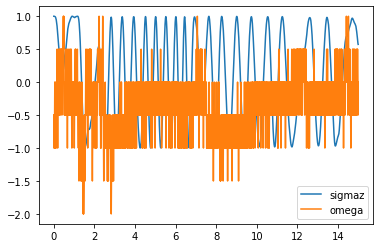

In [13]:
state, prev_state = env.reset(), None

state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
prev_state = state

z = list()
omega = list()

while True:
    action, action_p = net.sample_action(state)
    new_state, reward, done, info = env.step(action)
    state = torch.tensor(new_state, dtype=torch.float).view(-1).unsqueeze(0)
    z.append(state[0][-1])
    omega.append(state[0][3])
    if done:
      break

times = np.array(range(len(z)))*dt

plt.plot(times, z, label="sigmaz")
plt.plot(times, np.array(omega), label="omega")
plt.legend()
plt.show()